# Figure 1. SALLJ Climatology

Plot domain and variables used for EOF analysis

In [12]:
# Import Python modules
import os, sys
import numpy as np
import pandas as  pd
import xarray as xr
# plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import seaborn as sns
import cmocean.cm as cmo
import cmocean
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


from pathlib import Path

### Import my modules

In [2]:
# Set path to module directory
sys.path.append('/Users/tessamontini/repos/montini-phd/modules/')

# Imports
from plotter import draw_basemap


### Set up paths

In [3]:
# Set up paths
home = Path.home()                 # users home directory
root = home/'repos'/'montini-phd'    # project root directory
path_to_data = root/'data'           # data directory (input data, read only)
path_to_out = root/'out'             # directory for storing numerical results and intermediate datafiles (read & write
path_to_figs = root/'figs'           # directory for storing figures


In [4]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)
rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'


In [5]:
# label strings

ivt_units = 'kg m$^{-1}$ s$^{-1}$'

## Data

### 1) SALLJ time series

In [6]:
# Read CSV data into pandas DataFrame
filepath = path_to_data / 'erai.llj.day.1979-2016.csv'
df = pd.read_csv(filepath)

# Add datetime column
df['dates'] = pd.date_range(start='1979-01-01',end='2016-12-31',freq='D')

# Set the index to `dates`
df.set_index('dates', inplace=True)

# Add column of LLJ days (no LLJ day eq 0; LLJ day eq 1)
df['llj'] = 0
idx = (df['llj_sc'] > 0) | (df['llj_ma'] > 0)
df.loc[idx, 'llj'] = 1

# Add column of LLJ locations ('SC', 'MA', 'SC/MA', nan)
df['location'] = np.nan

idx = (df['llj_sc'] == 1) & (df['llj_ma'] == 0)
df.loc[idx, 'location'] = 'SC'

idx = (df['llj_sc'] == 0) & (df['llj_ma'] == 1)
df.loc[idx, 'location'] = 'MA'

idx = (df['llj_sc'] == 1) & (df['llj_ma'] == 1)
df.loc[idx, 'location'] = 'SC/MA'

# Show table
#df.head()

### 2) ERA reanalysis

In [7]:
# Reanalysis data (read data into xarray datasets)
f1 = xr.open_dataset(path_to_data/'era5_ivte_day_1979-2016_sam025.nc')
f2 = xr.open_dataset(path_to_data/'era5_ivtn_day_1979-2016_sam025.nc')

# merge variables into single dataset
era = xr.merge([f1,f2])

# Add LLJ time series to era5; set as coordinate variables
era['llj'] = ('time', df.llj)
era = era.set_coords('llj')

era['location'] = ('time', df.location)
era = era.set_coords('location')

# print dataset
#print(era)

### Select data subset

In [8]:
# Trim date range
start_date = '1979-11-01'
end_date = '2016-03-31'
idx = slice(start_date, end_date)
era = era.sel(time=idx)

# Select NDJFM months
idx = (era.time.dt.month >= 11) | (era.time.dt.month <= 3)
era = era.sel(time=idx)

# Select lat/lon grid
lonmin = -83
lonmax = -32
latmin = -47
latmax =  10
era = era.sel(longitude=slice(lonmin,lonmax), latitude=slice(latmax,latmin))

# Subset of LLJ days
idx = (era.llj >= 1)
era_llj = era.sel(time=idx)

#print(era_llj)

## Calculate climatology

In [9]:
era_llj_clim = era_llj.mean(dim='time')
#print(era_llj_clim, '\n')

## Create figure

In [10]:
# Data for plotting
lons = era_llj_clim.longitude.values
lats = era_llj_clim.latitude.values
uvec = era_llj_clim.ivte.values
vvec = era_llj_clim.ivtn.values
ivt = np.sqrt(uvec**2 + vvec**2)

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(-80,lonmax,20)
dy = np.arange(-40,latmax,20)

# set seaborn style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})


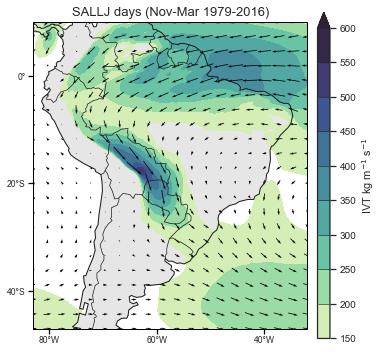

In [18]:

cmap = cmo.deep
clipcmap = cmocean.tools.crop_by_percent(cmap, 5, which='both', N=None)


# Create figure
fig = plt.figure(figsize=(6,6))

# Add plot axes and draw basemap
ax = fig.add_subplot(111, projection=mapcrs)
#ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)

# Basemap
ax.set_extent([lonmin,lonmax,latmin,latmax], crs=mapcrs)
ax.add_feature(cfeature.LAND, facecolor='0.9') 
ax.add_feature(cfeature.BORDERS, edgecolor='0.1', linewidth=0.7)
ax.add_feature(cfeature.COASTLINE, edgecolor='k', linewidth=1.0)
# xticks
ax.set_xticks(dx, crs=mapcrs)      
lon_formatter = LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
# yticks
ax.set_yticks(dy, crs=mapcrs)
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
# tick params
ax.tick_params(direction='out', labelsize=8.5, length=5, pad=2, color='black')    

# IVT (filled contour)
clevs_ivt = np.arange(150,601,50)
cf = ax.contourf(lons, lats, ivt, transform=datacrs, extend='max',
                levels=clevs_ivt, cmap=clipcmap)

# IVT vectors
ax.quiver(lons, lats, uvec, vvec, transform=datacrs,
    color='black', regrid_shape=20, pivot='middle')

# Colorbar 
cb = fig.colorbar(cf, orientation='vertical', drawedges=True, pad=0.03, aspect=25)
cb.set_label('IVT kg m$^{-1}$ s$^{-1}$', fontsize=11)
cb.ax.tick_params(labelsize=10)

# Title
ax.set_title('SALLJ days (Nov-Mar 1979-2016)', loc='center', fontsize=13)

# show figure
filepath = home/'Desktop' / 'fig1.png'
plt.savefig(filepath, bbox_inches='tight', dpi=200)
plt.show()

# Create figure
# fig = plt.figure(figsize=(5,6))

# # Add plot axes and draw basemap
# ax = fig.add_subplot(111, projection=mapcrs)
# ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)

# # IVT filled contour
# clevs_ivt = np.arange(100,601,50)
# cf = ax.contourf(lons, lats, ivt, transform=datacrs, levels=clevs_ivt, cmap='cmo.deep')

# Colorbar
# cb = plt.colorbar(cf, orientation='horizontal', shrink=0.8, pad=0.08, drawedges=True)
# ivt_label = 'IVT ('+ ivt_units+ ')'
# cb.set_label(ivt_label, fontsize=10)
# cb.ax.tick_params(labelsize=9)

# IVT vectors
# ax.quiver(lons, lats, uvec, vvec, transform=datacrs,
#           color='black', regrid_shape=22, pivot='middle')
